In [ ]:
# Instalação de arquivos necessários
!pip install python-docx
!pip install pymupdf
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00


In [ ]:
# Importação de bibliotecas
from google.colab import files
from docx import Document
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import matplotlib.pyplot as plt
import fitz
import re

In [ ]:
# Upload manual dos arquivos necessários (encontrados na pasta 'content')
uploaded = files.upload()

Saving DICIONARIO_DE_DADOS.docx to DICIONARIO_DE_DADOS.docx
Saving doencas_respiratorias_cronicas.pdf to doencas_respiratorias_cronicas.pdf


In [ ]:
# Funções para extrair conteúdo dos arquivos

# Extração de texto do .docx
def extract_text_from_docx(file_path):
  doc = Document(file_path)
  texts = []

  # Extrai textos fora das tabelas
  for p in doc.paragraphs:
    text = p.text.strip()
    if text:
      texts.append(text)

  # Extrai texto das tabelas
  for table in doc.tables:
    for row in table.rows:
      row_text = []
      for cell in row.cells:
        cell_text = cell.text.strip()
        if cell_text:
          row_text.append(cell_text)
      if row_text:
        texts.append(' | '.join(row_text))

  return '\n'.join(texts)


# Extração de texto do .pdf
def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    full_text = []

    for page in doc:
        text = page.get_text("text")
        # Limpeza leve: remove espaços múltiplos, quebra em parágrafos
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\s([.,;:])', r'\1', text)  # remove espaço antes de pontuação
        full_text.append(text.strip())

    return "\n".join(full_text)

In [ ]:
# Função para dividir em blocos menores
def split_context(text, max_len=1500):
    sentences = text.split('. ')
    blocks, current = [], ""
    for s in sentences:
        if len(current + s) <= max_len:
            current += s + ". "
        else:
            blocks.append(current.strip())
            current = s + ". "
    if current:
        blocks.append(current.strip())
    return blocks


In [ ]:
# Extração dos documentos
docx_text = extract_text_from_docx('/content/DICIONARIO_DE_DADOS.docx')
pdf_text = extract_text_from_pdf('/content/doencas_respiratorias_cronicas.pdf')

In [ ]:
# Aplicação dos modelos nas perguntas

# Modelos de teste
model_names = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "timpal0l/mdeberta-v3-base-squad2"
]

documentos = {
    "Dicionário de Dados": docx_text,
    "Doenças Respiratórias Crônicas": pdf_text
}

# Perguntas e respostas para cada documento
perguntas_respostas_por_doc = {
    "Dicionário de Dados": {
        "Qual o nome da tabela LFCES004 no banco de produção federal?": "TB_ESTABELECIMENTO",
        "Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?": "Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.)",
        "Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?": "1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião"
    },
    "Doenças Respiratórias Crônicas": {
        "Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?": "Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",
        "Qual é a definição clássica de sintomático respiratório?": "É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",
        "Como a tosse pode ser classificada?": "Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas."
    }
}

resultados = []

for model_name in model_names:
    print(f"Rodando Modelo: {model_name}")
    qa = pipeline("question-answering", model=model_name, tokenizer=model_name)

    for nome_doc, perguntas_respostas in perguntas_respostas_por_doc.items():
        contexto = documentos[nome_doc]
        blocos = split_context(contexto, 1500)

        for pergunta, resposta_correta in perguntas_respostas.items():
            print(f"Rodando Pergunta: {pergunta}")
            melhor_resposta = {"answer": "", "score": 0.0}
            for bloco in blocos:
              if not bloco.strip():
                continue
              try:
                resultado = qa(question=pergunta, context=bloco)
                if resultado["score"] > melhor_resposta["score"]:
                  melhor_resposta = resultado
              except Exception as e:
                print(f"Erro ao processar bloco: {e}")
                continue

            resposta_modelo = melhor_resposta["answer"]
            score = melhor_resposta["score"]

            resultados.append({
                "Modelo": model_name,
                "Documento": nome_doc,
                "Pergunta": pergunta,
                "Resposta": resposta_modelo,
                "Resposta Esperada": resposta_correta,
                "Confiança": round(score, 4)
            })

Rodando Modelo: deepset/roberta-base-squad2


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?
Rodando Modelo: distilbert-base-cased-distilled-squad


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?
Rodando Modelo: timpal0l/mdeberta-v3-base-squad2


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0


Rodando Pergunta: Qual o nome da tabela LFCES004 no banco de produção federal?
Rodando Pergunta: Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?
Rodando Pergunta: Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?
Rodando Pergunta: Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?
Rodando Pergunta: Qual é a definição clássica de sintomático respiratório?
Rodando Pergunta: Como a tosse pode ser classificada?


In [ ]:
# Avaliação manual + Similaridade semântica

# Avaliação manual
def avaliar_resposta(r_modelo, r_correta):
    r_modelo = r_modelo.lower().strip()
    r_correta = r_correta.lower().strip()
    if r_modelo == r_correta:
        return "✔️"
    elif r_modelo in r_correta or r_correta in r_modelo:
        return "➖"
    else:
        return "❌"

# Carrega modelo para embeddings
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Tabela com avaliações
avaliacoes = []

for r in resultados:
    r_modelo = r["Resposta"]
    r_correta = r["Resposta Esperada"]

    # Similaridade
    emb1 = embedding_model.encode(r_modelo, convert_to_tensor=True)
    emb2 = embedding_model.encode(r_correta, convert_to_tensor=True)
    similaridade = util.cos_sim(emb1, emb2).item()

    # Avaliação manual
    avaliacao = avaliar_resposta(r_modelo, r_correta)

    avaliacoes.append({
        "Documento": r["Documento"],
        "Pergunta": r["Pergunta"],
        "Modelo": r["Modelo"],
        "Resposta": r_modelo,
        "Resposta Esperada": r_correta,
        "Avaliação": avaliacao,
        "Similaridade": round(similaridade, 4),
        "Confiança": r["Confiança"]
    })

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]



Resultados para: deepset/roberta-base-squad2


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
0,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,deepset/roberta-base-squad2,NOT NULL,TB_ESTABELECIMENTO,❌,0.191800,0.309700
1,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",deepset/roberta-base-squad2,LFCES002,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,-0.062700,0.008400
2,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",deepset/roberta-base-squad2,NFCES110,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.007600,0.038200
3,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,deepset/roberta-base-squad2,as crianças,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.147200,0.096900
4,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,deepset/roberta-base-squad2,se possível,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.258800,0.228200
5,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,deepset/roberta-base-squad2,quanto à gravidade,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,❌,0.281600,0.261700




Resultados para: distilbert-base-cased-distilled-squad


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
6,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,distilbert-base-cased-distilled-squad,Ensinos F – Hosp,TB_ESTABELECIMENTO,❌,0.205600,0.474900
7,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",distilbert-base-cased-distilled-squad,Ensinos F – Hosp,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.359600,0.663900
8,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",distilbert-base-cased-distilled-squad,Ensinos F – Hosp,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.170900,0.579200
9,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,distilbert-base-cased-distilled-squad,Broncodilatadores,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.258500,0.125500
10,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,distilbert-base-cased-distilled-squad,Quadro 5.5,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.068600,0.304900
11,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,distilbert-base-cased-distilled-squad,Aguda,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.450400,0.493500




Resultados para: timpal0l/mdeberta-v3-base-squad2


,Documento,Pergunta,Modelo,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
12,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,timpal0l/mdeberta-v3-base-squad2,TB_ESTABELECIMENTO,TB_ESTABELECIMENTO,✔️,1.000000,0.860800
13,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",timpal0l/mdeberta-v3-base-squad2,Quantidade de Leitos Disponíveis para o SUS.(,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),➖,0.885800,0.141400
14,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",timpal0l/mdeberta-v3-base-squad2,1 – Secretaria Estadual,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",➖,0.520300,0.011000
15,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,timpal0l/mdeberta-v3-base-squad2,"tabagismo,","Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",➖,0.303000,0.724600
16,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,timpal0l/mdeberta-v3-base-squad2,concomitância,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.187900,0.569800
17,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,timpal0l/mdeberta-v3-base-squad2,crônica,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.337800,0.656500


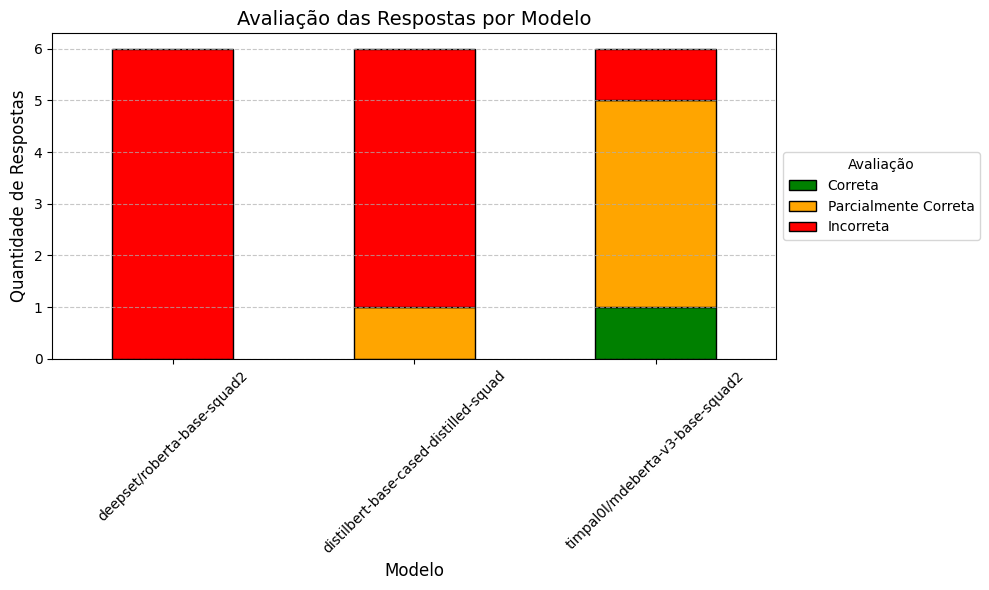

In [ ]:
# Exibir tabela de avaliação

def exibir_resultados_formatados(df):
    modelos = df["Modelo"].unique()

    for modelo in modelos:
        print(f"\n\nResultados para: {modelo}")
        df_modelo = df[df["Modelo"] == modelo]
        styled = df_modelo.style.set_properties(**{'text-align': 'center'}) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
            .set_caption(f"Modelo: {modelo}")
        display(styled)

    print("\n\n\n")
    # Gráfico comparativo de avaliações
    comparativo = df.groupby(["Modelo", "Avaliação"]).size().unstack(fill_value=0)

    # Ordena colunas para manter ✔️ ➖ ❌ nessa ordem
    colunas_ordenadas = ["✔️", "➖", "❌"]
    comparativo = comparativo[[col for col in colunas_ordenadas if col in comparativo.columns]]

    # Define cores personalizadas
    cores = {
        "✔️": "green",
        "➖": "orange",
        "❌": "red"
    }
    cores_usadas = [cores[c] for c in comparativo.columns]

    # Plota
    ax = comparativo.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=cores_usadas,
        edgecolor='black'
    )

    plt.title("Avaliação das Respostas por Modelo", fontsize=14)
    plt.xlabel("Modelo", fontsize=12)
    plt.ylabel("Quantidade de Respostas", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Legenda personalizada
    legenda = {
        "✔️": "Correta",
        "➖": "Parcialmente Correta",
        "❌": "Incorreta"
    }
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [legenda.get(lbl, lbl) for lbl in labels]
    ax.legend(
    handles, new_labels,
    title="Avaliação",
    loc='center left',
    bbox_to_anchor=(1, 0.5)
    )

    plt.tight_layout()
    plt.show()


df_avaliacao = pd.DataFrame(avaliacoes)
exibir_resultados_formatados(df_avaliacao)